In [102]:
import numpy as np

#visuals
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

#Interactive
from ipywidgets.widgets import * 
import ipywidgets as widgets

#is vectorization useful here?
import time

#Hugo code
import Utility
import PythonKEX 

In [103]:
#use normalized sinogram (from e7_recon)
# "applied corrections:={normalization,deadtime,randoms smoothing,randoms subtraction}"
# number format:=float
# number of bytes per pixel:=4, that is 4*8 = 32 bits
# it might be unsigned? 
datatype = np.float32
datatype = '<f4'

sinogram_options = [r"C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/CylinderPET-00-sino-norm_00.s",
                    r"C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/CylinderPET-01-sino-norm_00.s",
                    r"C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/KanylPET-00-sino-norm_00.s",
                    r"C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/KanylPET-01-sino-norm_00.s"]

sinogram_4D = []
sinogram_shape = (Utility.NUMBER_OF_TOFBINS,
                  Utility.NUMBER_OF_SINOGRAMS,
                  Utility.NUMBER_OF_VIEWS, 
                  Utility.NUMBER_OF_PROJECTIONS)
for path in sinogram_options:
    with open(path, 'rb') as file:
        sinogram_1D = np.fromfile(file, dtype=datatype)
        #check value range, set lowest to 0
        #using "ReLu"
        sinogram_1D = np.maximum(sinogram_1D, 0)
        sinogram_4D.append(np.reshape(sinogram_1D, newshape=sinogram_shape, order='C'))

print("1D size", np.size(sinogram_1D))
print("4D size", np.prod(sinogram_shape))
print("ratio 4D/1D", np.prod(sinogram_shape)/np.size(sinogram_1D))

1D size 542505600
4D size 542505600
ratio 4D/1D 1.0


C:\Users\petct\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


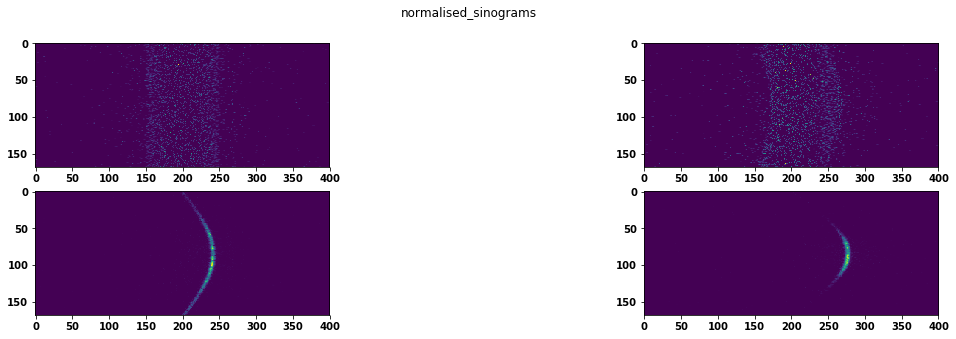

In [3]:
#plot sinograms
number_of_sinograms = len(sinogram_4D)
scale = 5
plt.figure(figsize=(scale*number_of_sinograms, scale))
tof = 0
mi = 50
for k, sino in enumerate(sinogram_4D):
    plt.subplot(2,number_of_sinograms/2, k+1)
    plt.imshow(sino[tof, mi])
    plt.suptitle("normalised_sinograms")
plt.show()

In [104]:
#look at histogram at fixed tof, transaxial angle and segment
def histogramDirectionView(segment_index=0, transaxial_angle=0, tof=0, bSaveFile=False):
    mi_low, mi_high = Utility.mi_bounds_from_seg(segment_index=segment_index)
    plt.figure(figsize=(15,4))
    #tof = Utility.TOF_OFFSET_MAP[tof]+ len(Utility.TOF_OFFSET_MAP)//2
    
    plt.imshow(sinogram_4D[tof,mi_low:mi_high,transaxial_angle,:])
    plt.xlabel(Utility.HISTOGRAM_DIMENSION_TITLES[3])
    plt.ylabel(Utility.HISTOGRAM_DIMENSION_TITLES[1] + " in segment")

    plt.show()

In [105]:
#fix tx angle (and tof and mi), calculate COM(ro)
mean_ro = []
sum_ro = []
print("histogram dimension titles\n", Utility.HISTOGRAM_DIMENSION_TITLES)
for sino in sinogram_4D:
    ta = time.time()
    mean_ro.append(Utility.CenterOfMassMultiplication(sino, axis=(3,)))
    sum_ro.append(np.sum(sino, axis=(3,)))
    tb = time.time()
    print("time mean ro passed", tb-ta)

histogram dimension titles
 ['TOF bin ', 'michelogram bin ', 'transaxial angle bin ', 'radial offset bin ']
time mean ro passed 4.503190994262695
time mean ro passed 4.2696967124938965
time mean ro passed 4.497141122817993
time mean ro passed 4.36398983001709


(1, 13, 621, 168)
['C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/CylinderPET-00-sino-norm_00.s', 'C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/CylinderPET-01-sino-norm_00.s', 'C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/KanylPET-00-sino-norm_00.s', 'C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/KanylPET-01-sino-norm_00.s']


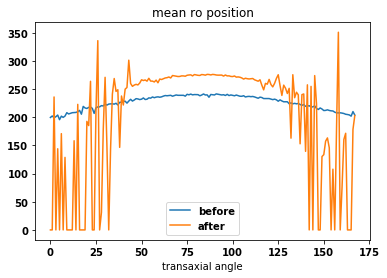

(13, 621, 168)


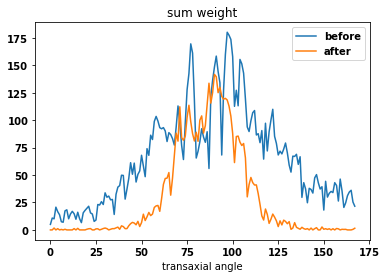

In [118]:
print(mean_ro[0].shape)
print(sinogram_options)
a = 2
b = a+1
tof =0
mi = 50
plt.plot(mean_ro[a][0,tof,mi])
plt.plot(mean_ro[b][0,tof,mi])
plt.legend(["before", "after"])
plt.xlabel("transaxial angle")
plt.title("mean ro position")
plt.show()

print(sum_ro[0].shape)
plt.plot(sum_ro[a][tof,mi])
plt.plot(sum_ro[b][tof,mi])
plt.title("sum weight")
plt.xlabel("transaxial angle")
plt.legend(["before", "after"])

plt.show()



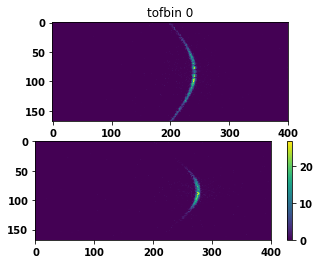

In [130]:
#look at tofbin tof
tof = 0
plt.subplot(2,1,1)
plt.imshow(sinogram_4D[a][tof,mi])

plt.title("tofbin " + str(tof))

plt.subplot(2,1,2)
plt.imshow(sinogram_4D[b][tof,mi])
plt.colorbar()
plt.show()

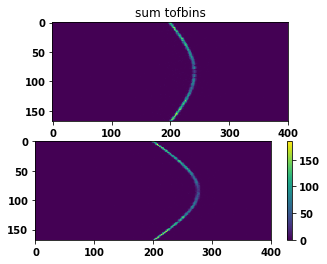

In [123]:
#sum tofbins
plt.subplot(2,1,1)
plt.imshow(np.sum(sinogram_4D[a],axis=0)[mi])
plt.title("sum tofbins")
plt.subplot(2,1,2)
plt.imshow(np.sum(sinogram_4D[b],axis=0)[mi])
plt.colorbar()

plt.show()

In [7]:
print(np.max(sum_ro[0]))
print(np.max(mean_ro[0]))

51.2585
398.37440603249337


In [8]:
print("ratio", np.prod(sinogram_4D[0].shape) / (Utility.NUMBER_OF_PROJECTIONS*np.size(mean_ro[0])))

ratio 1.0


In [9]:
# get the bins
ta = time.time()
ranges = []
for k in sinogram_4D[0].shape:
    if k != Utility.NUMBER_OF_PROJECTIONS:
        ranges.append(np.arange(k))

mesh = np.meshgrid(ranges[0], ranges[1], ranges[2])
#mesh = np.meshgrid(np.arange(Utility.NUMBER_OF_TOFBINS), [50], np.arange(Utility.NUMBER_OF_VIEWS))
print("mesh shape", mesh[0].shape)
#print(np.unique(mesh[2]))

histogram_bins = np.zeros((np.ndim(sinogram_4D[0]), np.size(mesh[0])), dtype=int)
for k,m in enumerate(mesh):
    histogram_bins[k] = m.flatten()

if False:
    mi= 50
    right_mi = mesh[1].flatten() == mi
    print(np.size(mesh[1]))
    print(np.sum(right_mi))
    histogram_bins = histogram_bins[:,right_mi]

image_bins = []
for k,sino in enumerate(sinogram_4D):
    #specify the com ro bins
    #print("mean ro[k].shape", mean_ro[k].shape)
    histogram_bins[3] = mean_ro[k].flatten()
    #calculate image bins
    image_bins.append(Utility.imageBinFromHistogramBin(histogram_bins, offsetTOF=True, verbose=False))
tb = time.time()
print("time for image bin calculation", tb-ta)



mesh shape (621, 13, 168)
time for image bin calculation 1.3684806823730469


In [28]:
#get histogram image
ta = time.time()
histogram_image = []
for k,img_bin in enumerate(image_bins):

    #add to histogram image
    target = np.zeros(Utility.IMAGE_SHAPE)
    valid_bins = Utility.bValidBin(img_bin, target.shape)
    np.add.at(target, tuple(img_bin[:,valid_bins]), sum_ro[k].flatten()[valid_bins])
    histogram_image.append(target)

tb= time.time()
print("time for image histogram", tb-ta)

time for image histogram 0.7661592960357666


In [29]:
#center of image mass
ta = time.time()
FOV_histo_com = []
for k,histo in enumerate(histogram_image):
    com = Utility.CenterOfMassMultiplication(histo)
    FOV_histo_com.append(com)
    print("file", sinogram_options[k].split('/')[-1])
    print("center of mass", com)
tb=time.time()
print("time for com calculation", tb-ta)

file CylinderPET-00-sino-norm_00.s
center of mass [47.38951534 98.5936719  99.74102132]
file CylinderPET-01-sino-norm_00.s
center of mass [ 48.00440651 103.42448428  99.80694341]
file KanylPET-00-sino-norm_00.s
center of mass [ 50.71679102 108.49290251  98.86897782]
file KanylPET-01-sino-norm_00.s
center of mass [ 53.92533551 118.08457996  98.8525317 ]
time for com calculation 0.4080052375793457


In [30]:
#center of all image bins
complete_histo_com = []
print("image bins shape\n", image_bins[0].shape)
for k, img_bin in enumerate(image_bins):
    com = np.mean(img_bin, axis=1)
    complete_histo_com.append(com)
    print("file", sinogram_options[k].split('/')[-1])
    print("center of mass", com)

image bins shape
 (3, 1356264)
file CylinderPET-00-sino-norm_00.s
center of mass [ 53.62317661  84.56420874 101.18503625]
file CylinderPET-01-sino-norm_00.s
center of mass [ 53.63764872  88.01706305 101.25567589]
file KanylPET-00-sino-norm_00.s
center of mass [ 53.66339518  72.21089109 100.96704329]
file KanylPET-01-sino-norm_00.s
center of mass [ 53.65490494  76.24905254 101.00039963]


In [74]:
# get recon. center of mass for comparison
#calculate COM of recon for comparison
recon_paths = []
#print("documentation\n", PythonKEX.define_KEX_dataset.__doc__)
for b in [False,True]:
    lm,sino,phantom,recon = PythonKEX.define_KEX_dataset(isKanyl=b)
    recon_paths += recon

recon_COM = []
for path in recon_paths:
    
    recon_pixels = Utility.get_pixels_hu(Utility.load_scan(path))
    if False:
        print("last path", path.split('/')[-1])
        print(recon_pixels.shape)
        print("min", np.min(recon_pixels))
        print("max", np.max(recon_pixels))
        print("recon. center of mass", com)
    com =Utility.CenterOfMassMultiplication(recon_pixels, verbose=False, convert_to_datatype=np.int64)
    
    recon_COM.append(com)

In [101]:
z_slide = widgets.IntSlider(min=0, max=109-1)
if False:
    print("histo. image shape", histogram_image[0].shape)
    print("recon_com shape", recon_COM[0].shape)
    print("recon_COM [0]=",recon_COM[0])
    print("recon_COM [0] datatype", recon_COM[0].dtype)

def f(z):
    number_of_histograms = len(histogram_image)
    scale = 14
    plt.figure(figsize=(scale, scale))
    for k,histo in enumerate(histogram_image):
        plt.subplot(2,number_of_histograms/2,k+1)
        plt.imshow(histo[z])
        plt.colorbar()
        
        plt.xlabel(Utility.IMAGE_DIMENSION_TITLES[2])
        plt.ylabel(Utility.IMAGE_DIMENSION_TITLES[1])
        
        filename = "file " + sinogram_options[k].split('/')[-1] 
        title_str = filename
        if True:
            recon_com_str = "red dot at recon. center of mass" 
            recon_com_str += "\n[z y x] =" +str(np.array(recon_COM[k], dtype=int))
            histo_com_str = "white dot at histo. center of mass" 
            histo_com_str += "\n[z y x] =" +str(np.array(FOV_histo_com[k], dtype=int))
            title_str = filename + "\n" + recon_com_str + "\n" + histo_com_str
            
            #add axes for orientation
            alpha = 0.2
            plt.axvline(x=[100],color='red', alpha=alpha)
            plt.axhline(y=[100],color='red',alpha=alpha)
            #add com points
            plt.scatter(recon_COM[k][2], recon_COM[k][1],color='r', marker='.')
            plt.scatter(FOV_histo_com[k][2], FOV_histo_com[k][1],color='w', marker='.')
            
        plt.title(title_str)
    
    plt.suptitle("z=" +str(z))

    plt.show()
    return z

interact(f,z=z_slide)    ;

interactive(children=(IntSlider(value=0, description='z', max=108), Output()), _dom_classes=('widget-interact'…

In [100]:
x_slide = widgets.IntSlider(min=0, max=200-1)

def f(x):
    number_of_histograms = len(histogram_image)
    scale = 14
    plt.figure(figsize=(scale, scale))
    for k,histo in enumerate(histogram_image):
        plt.subplot(2,number_of_histograms/2,k+1)
        plt.imshow(histo[:,:,x])
        plt.colorbar()
        
        plt.xlabel(Utility.IMAGE_DIMENSION_TITLES[1])
        plt.ylabel(Utility.IMAGE_DIMENSION_TITLES[0])
        
        filename = "file " + sinogram_options[k].split('/')[-1] 
        title_str = filename
        if True:
            recon_com_str = "red dot at recon. center of mass" 
            recon_com_str += "\n[z y x] =" +str(np.array(recon_COM[k], dtype=int))
            histo_com_str = "white dot at histo. center of mass" 
            histo_com_str += "\n[z y x] =" +str(np.array(FOV_histo_com[k], dtype=int))
            title_str = filename + "\n" + recon_com_str + "\n" + histo_com_str
            
            #add axes for orientation
            alpha = 0.2
            plt.axvline(x=[100],color='red', alpha=alpha)
            plt.axhline(y=[55],color='red',alpha=alpha)
            #add com points
            plt.scatter(recon_COM[k][1], recon_COM[k][0],color='r', marker='.')
            plt.scatter(FOV_histo_com[k][1], FOV_histo_com[k][0],color='w', marker='.')
        
        plt.title(title_str)
        
    
    plt.suptitle("x=" +str(x))

    plt.show()
    return x

interact(f,x=x_slide)    ;

interactive(children=(IntSlider(value=0, description='x', max=199), Output()), _dom_classes=('widget-interact'…

In [99]:
print(np.sum(histogram_image[0]-histogram_image[1]))
print(np.sum(histogram_image[2]-histogram_image[3]))

4102.697476916015
1298514.9833041057


In [15]:
# meshgrid is slow, but should work
# for some reason, the grid is shaped (x2 by x1 by x3 by x4)
#this should not be an issue however
#for memory reasons, it might be better to split it up

M = np.meshgrid(np.arange(Utility.NUMBER_OF_SINOGRAMS), 
                np.arange(Utility.NUMBER_OF_VIEWS),
                np.arange(Utility.NUMBER_OF_PROJECTIONS))
print(M[0].shape)
for m in M:
    print(np.max(m))

M_flat = []
for m in M:
    M_flat.append(m.flatten())

M_flat = np.array(M_flat)
print("M_flat shape", M_flat.shape)

histogram_image = np.zeros(Utility.IMAGE_SHAPE)

for tofbin in range(Utility.NUMBER_OF_TOFBINS):
    histogram_bins = (tofbin,) + tuple(M_flat)
    print("done index list")
    img_bins = Utility.imageBinFromHistogramBin(histogramBin=histogram_bins, offsetTOF=True,delays=False)
    print("done calculating img bins, shape", img_bins.shape, "tofbin", tofbin)
    bValid = Utility.bValidBin(img_bin, histogram_image.shape)
    print("done valid bins, shape", bValid.shape)
    valid_histo_bins = [tofbin] + M_flat[:,bValid]
    valid_img_bins = img_bins[:, bValid]
    np.add.at(histogram_image, tuple(valid_img_bins), sinogram_4D[tuple(valid_histo_bins)])
    print("done add to histo image")

(168, 621, 400)
620
167
399
M_flat shape (3, 41731200)
done index list
done calculating img bins, shape (3, 41731200) tofbin 0
done valid bins, shape (1356264,)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 41731200 but corresponding boolean dimension is 1356264

In [ ]:
A = [0,0,0,0]
B = Utility.imageBinFromHistogramBin(A)
print(B)

In [ ]:
print([1] + [[2,3],3])

In [ ]:
print(np.max(histogram_bins[0]))
print(np.max(histogram_bins[1]))
